## 1. 数据准备

### 1.1 代码包引入

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch import optim
import numpy as np
from tqdm import *
import matplotlib.pyplot as plt
import re
import string
from collections import Counter  # 计数类

### 1.2 数据整理

In [2]:
with open('data/dataset.txt','r',encoding='utf-8') as f:
    datas = f.readlines()
datas[:10]

['是时候教教你针线活了\t手把手教\t别，不用。\n',
 '谢谢你所做的一切\t你开心就好\t开心\t嗯因为你的心里只有学习\t某某某，还有你\t这个某某某用的好\t\n',
 '今天好点了吗？\t一天比一天严重\t吃药不管用，去打一针。别拖着\t\n',
 '加油，三月动起来，五月笑起来\t正解你为什么就那么厉害呢\t哈哈，没办法，智商就是这么高\t你这是要开始得瑟了吗！好啦！你最厉害！\t哈哈哈哈\t\n',
 '因为我网络差吗，加载不出来啊\t是什么网络啊，移动的可能比较慢\t啊真的是我自家网络的问题，用别家的就好了\t\n',
 '这个側颜可以\t这个繁体很厉害\t为了配你的颜\t哥，\t\n',
 '对啊。你以为你是谁。留言就要回复吗\t对啊，什么逻辑\t大概是\n',
 '保留几分\t晾毛巾晾毛巾叫你天天晾毛巾\t看看几点了还不快去吃饭\t\t\n',
 '哈哈哈哈哈哈哈哈哈哈哈哈\t你哈哈个啥\t别人晒得都是某某某搞事情为啥只有你是瘦了！太尼玛懂你了笑哭我了\t这个太假了\t\n',
 '看着就难吃\t又不是你吃，莫操心\t心疼你\t滚蛋\t不滚\n']

In [3]:
# 查看特殊字符
content = ''.join(datas)
special_char = re.sub(r'[\u4e00-\u9fa5]', ' ', content)  # 匹配中文，将中文替换掉

print(set(special_char) - set(string.ascii_letters) - set(string.digits))

{'，', ' ', '\n', "'", '？', '》', '《', '.', '。', '！', ',', '"', ';', '!', '、', '?', '’', '\t', '‘', '；'}


In [4]:
# 词元化
def tokenize(datas):
    # 存储词元
    tokens = []
    for data in datas:
        data=data.strip().replace("\n","")
        token = [i if i!='\t' else "<sep>" for i in data]+['<sep>']
        tokens.append(token)
    return tokens

tokens = tokenize(datas)
print("tokens:", tokens[:6])

tokens: [['是', '时', '候', '教', '教', '你', '针', '线', '活', '了', '<sep>', '手', '把', '手', '教', '<sep>', '别', '，', '不', '用', '。', '<sep>'], ['谢', '谢', '你', '所', '做', '的', '一', '切', '<sep>', '你', '开', '心', '就', '好', '<sep>', '开', '心', '<sep>', '嗯', '因', '为', '你', '的', '心', '里', '只', '有', '学', '习', '<sep>', '某', '某', '某', '，', '还', '有', '你', '<sep>', '这', '个', '某', '某', '某', '用', '的', '好', '<sep>'], ['今', '天', '好', '点', '了', '吗', '？', '<sep>', '一', '天', '比', '一', '天', '严', '重', '<sep>', '吃', '药', '不', '管', '用', '，', '去', '打', '一', '针', '。', '别', '拖', '着', '<sep>'], ['加', '油', '，', '三', '月', '动', '起', '来', '，', '五', '月', '笑', '起', '来', '<sep>', '正', '解', '你', '为', '什', '么', '就', '那', '么', '厉', '害', '呢', '<sep>', '哈', '哈', '，', '没', '办', '法', '，', '智', '商', '就', '是', '这', '么', '高', '<sep>', '你', '这', '是', '要', '开', '始', '得', '瑟', '了', '吗', '！', '好', '啦', '！', '你', '最', '厉', '害', '！', '<sep>', '哈', '哈', '哈', '哈', '<sep>'], ['因', '为', '我', '网', '络', '差', '吗', '，', '加', '载', '不', '出', '来', '啊', '<se

### 1.3 构建词表

In [5]:
flatten = lambda l: [item for sublist in l for item in sublist]  # 展平数组
# 构建词表
class Vocab:
    def __init__(self, tokens):
        self.tokens = tokens  # 传入的tokens是二维列表
        self.token2index = {'<pad>': 0, '<unk>': 1, '<seq>': 2}  # 先存好特殊词元
        # 将词元按词频排序后生成列表
        self.token2index.update({
            token: index + 3
            for index, (token, freq) in enumerate(
                sorted(Counter(flatten(self.tokens)).items(), key=lambda x: x[1], reverse=True))
        })
        # 构建id到词元字典
        self.index2token = {index: token for token, index in self.token2index.items()}

    def __getitem__(self, query):
        # 单一索引
        if isinstance(query, (str, int)):
            if isinstance(query, str):
                return self.token2index.get(query, 0)
            elif isinstance(query, (int)):
                return self.index2token.get(query, '<unk>')
        # 数组索引
        elif isinstance(query, (list, tuple)):
            return [self.__getitem__(item) for item in query]

    def __len__(self):
        return len(self.index2token)

#实例化词表
vocab = Vocab(tokens)
vocab_size = len(vocab)

### 1.4 构造数据集

In [6]:
# 构建自己的数据集类
class MyDataSet(Data.Dataset):
    def __init__(self,datas):
        self.datas = datas

    def __getitem__(self, item):
        data = self.datas[item]
        decoder_input = data[:-1]
        decoder_output = data[1:]

        decoder_input_len = len(decoder_input)
        decoder_output_len = len(decoder_output)

        return {"decoder_input":decoder_input,"decoder_input_len":decoder_input_len,
                "decoder_output":decoder_output,"decoder_output_len":decoder_output_len}

    def __len__(self):
        return len(self.datas)

    def padding_batch(self,batch):
        # 批处理, 对每个批次的数据中，长度不够的序列填充<pad>
        decoder_input_lens = [d["decoder_input_len"] for d in batch]
        decoder_output_lens = [d["decoder_output_len"] for d in batch]

        decoder_input_maxlen = max(decoder_input_lens)
        decoder_output_maxlen = max(decoder_output_lens)

        for d in batch:
            d["decoder_input"].extend([vocab["<pad>"]]*(decoder_input_maxlen-d["decoder_input_len"]))
            d["decoder_output"].extend([vocab["<pad>"]]*(decoder_output_maxlen-d["decoder_output_len"]))
        decoder_inputs = torch.tensor([d["decoder_input"] for d in batch], dtype=torch.long)
        decoder_outputs = torch.tensor([d["decoder_output"] for d in batch], dtype=torch.long)
        return decoder_inputs,decoder_outputs

In [7]:
batch_size = 64
# 构造数据集
tokens_num = [[vocab[word] for word in line] for line in tokens] # 文本序列转id序列
dataset = MyDataSet(tokens_num)
data_loader = Data.DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.padding_batch)

## 2. 建立模型

### 2.1 掩码操作

In [8]:
# mask掉没有意义的占位符
def get_attn_pad_mask(seq_q, seq_k):                       # seq_q: [batch_size, seq_len] ,seq_k: [batch_size, seq_len]
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)          # 判断 输入那些含有P(=0),用1标记 ,[batch_size, 1, len_k]
    return pad_attn_mask.expand(batch_size, len_q, len_k)

# mask掉未来信息
def get_attn_subsequence_mask(seq):                               # seq: [batch_size, tgt_len]
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)          # 生成上三角矩阵,[batch_size, tgt_len, tgt_len]
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()  #  [batch_size, tgt_len, tgt_len]
    subsequence_mask = subsequence_mask.to(device)
    return subsequence_mask

### 2.2 注意力计算函数

In [9]:
# 缩放点积注意力计算
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is True.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V) # [batch_size, n_heads, len_q, d_v]
        return context, attn

#多头注意力计算
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)
        self.layernorm = nn.LayerNorm(d_model)
    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1,2) # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1,2) # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1,2) # V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size, n_heads, seq_len, seq_len]
        # context: [batch_size, n_heads, len_q, d_v], attn: [batch_size, n_heads, len_q, len_k]
        context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads * d_v) # context: [batch_size, len_q, n_heads * d_v]
        output = self.fc(context) # [batch_size, len_q, d_model]
        return self.layernorm(output + residual), attn

### 2.3 构建前馈网络

In [10]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False))
        self.layernorm = nn.LayerNorm(d_model)

    def forward(self, inputs):  # inputs: [batch_size, seq_len, d_model]
        residual = inputs
        output = self.fc(inputs)
        return self.layernorm(output + residual)  # 残差 + LayerNorm

### 2.4 解码器模块

In [11]:
# 解码器层
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, dec_self_attn_mask):
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        '''
        # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)  # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn


# 解码器模块
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs):
        '''
        dec_inputs: [batch_size, tgt_len]
        '''
        # 构建position embedding
        seq_len = dec_inputs.size(1)
        pos = torch.arange(seq_len, dtype=torch.long, device=device)
        pos = pos.unsqueeze(0).expand_as(dec_inputs)  # [seq_len] -> [batch_size, seq_len]

        word_emb = self.tgt_emb(dec_inputs)  # [batch_size, tgt_len, d_model]
        pos_emb = self.pos_emb(pos)  # [batch_size, tgt_len, d_model]
        dec_outputs = word_emb + pos_emb

        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)  # [batch_size, tgt_len, tgt_len]
        dec_self_attn_subsequent_mask = get_attn_subsequence_mask(dec_inputs)  # [batch_size, tgt_len]
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask),
                                      0)  # [batch_size, tgt_len, tgt_len]

        dec_self_attns = []
        for layer in self.layers:
            # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
            dec_outputs, dec_self_attn = layer(dec_outputs, dec_self_attn_mask)
            dec_self_attns.append(dec_self_attn)

        return dec_outputs, dec_self_attns

### 2.5 GPT模型

In [12]:
class GPT(nn.Module):
    def __init__(self):
        super(GPT, self).__init__()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, dec_inputs):
        """
        dec_inputs: [batch_size, tgt_len]
        """

        # dec_outpus: [batch_size, tgt_len, d_model], dec_self_attns: [n_layers, batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attns = self.decoder(dec_inputs)
        # dec_logits: [batch_size, tgt_len, tgt_vocab_size]
        dec_logits = self.projection(dec_outputs)
        return dec_logits.view(-1, dec_logits.size(-1)), dec_self_attns

    def answer(self, above): # 生成回复
        
        dec_input = [vocab[word] for word in above]
        dec_input.append(vocab['<sep>']) # 原始句子后面增加<sep>
        dec_input = torch.tensor(dec_input, dtype=torch.long, device=device).unsqueeze(0)

        # 循环生成下一个单词
        for i in range(100):

            dec_outputs, _ = self.decoder(dec_input)
            projected = self.projection(dec_outputs)
            prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
            next_id = prob.data[-1]

            if next_id == vocab["<sep>"]: # 到出现"<sep>"结束
                break

            dec_input = torch.cat(
                [dec_input.detach(), torch.tensor([[next_id]], dtype=dec_input.dtype, device=device)], -1)

        output = dec_input.squeeze(0)
        sequence = [vocab[int(id)] for id in output] # id转文字

        answer = "".join(sequence)
        answer = answer[answer.rindex("<sep>")+5: ] # 取最后一个<sep>后面部分, +5 是加上<seq>本身的长度

        return answer

## 3. 模型训练

In [13]:
# 定义超参数
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
seq_len = 300  # 序列最大长度
d_model = 768  # Embedding维度
d_ff = 2048  # 前馈层维度
d_k = d_v = 64  # QKV维度
n_layers = 6  # 解码器层数
n_heads = 8  # 多头注意力头数
batch_size = 64
epochs = 30

# 定义模型
model = GPT().to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_history = [] # 记录损失变化
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for i, (dec_inputs, dec_outputs) in enumerate(tqdm(data_loader)):
        optimizer.zero_grad()
        dec_inputs, dec_outputs =dec_inputs.to(device), dec_outputs.to(device)
        # outputs: [batch_size * tgt_len, tgt_vocab_size]
        outputs, dec_self_attns = model(dec_inputs)

        loss = criterion(outputs, dec_outputs.view(-1))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = epoch_loss / len(data_loader)
    loss_history.append(train_loss)   # 记录损失变化
    print(f'\tTrain Loss: {train_loss:.3f}')
    torch.save(model.state_dict(), 'model/gpt_chat.pt') # 保存模型

100%|██████████| 3895/3895 [18:04<00:00,  3.59it/s]


	Train Loss: 4.293


100%|██████████| 3895/3895 [18:05<00:00,  3.59it/s]


	Train Loss: 3.807


100%|██████████| 3895/3895 [17:51<00:00,  3.64it/s]


	Train Loss: 3.611


100%|██████████| 3895/3895 [17:50<00:00,  3.64it/s]


	Train Loss: 3.466


100%|██████████| 3895/3895 [17:51<00:00,  3.64it/s]


	Train Loss: 3.340


100%|██████████| 3895/3895 [17:50<00:00,  3.64it/s]


	Train Loss: 3.223


100%|██████████| 3895/3895 [17:51<00:00,  3.64it/s]


	Train Loss: 3.113


100%|██████████| 3895/3895 [17:50<00:00,  3.64it/s]


	Train Loss: 3.010


100%|██████████| 3895/3895 [17:50<00:00,  3.64it/s]


	Train Loss: 2.918


100%|██████████| 3895/3895 [17:50<00:00,  3.64it/s]


	Train Loss: 2.837


100%|██████████| 3895/3895 [17:49<00:00,  3.64it/s]


	Train Loss: 2.767


100%|██████████| 3895/3895 [17:50<00:00,  3.64it/s]


	Train Loss: 2.704


100%|██████████| 3895/3895 [17:49<00:00,  3.64it/s]


	Train Loss: 2.648


100%|██████████| 3895/3895 [17:50<00:00,  3.64it/s]


	Train Loss: 2.595


100%|██████████| 3895/3895 [17:49<00:00,  3.64it/s]


	Train Loss: 2.546


100%|██████████| 3895/3895 [17:50<00:00,  3.64it/s]


	Train Loss: 2.499


100%|██████████| 3895/3895 [17:49<00:00,  3.64it/s]


	Train Loss: 2.457


100%|██████████| 3895/3895 [17:49<00:00,  3.64it/s]


	Train Loss: 2.416


100%|██████████| 3895/3895 [17:50<00:00,  3.64it/s]


	Train Loss: 2.378


100%|██████████| 3895/3895 [17:51<00:00,  3.63it/s]


	Train Loss: 2.342


100%|██████████| 3895/3895 [17:52<00:00,  3.63it/s]


	Train Loss: 2.308


100%|██████████| 3895/3895 [18:05<00:00,  3.59it/s]


	Train Loss: 2.276


100%|██████████| 3895/3895 [18:08<00:00,  3.58it/s]


	Train Loss: 2.245


100%|██████████| 3895/3895 [18:08<00:00,  3.58it/s]


	Train Loss: 2.216


100%|██████████| 3895/3895 [18:08<00:00,  3.58it/s]


	Train Loss: 2.188


100%|██████████| 3895/3895 [18:08<00:00,  3.58it/s]


	Train Loss: 2.163


100%|██████████| 3895/3895 [18:08<00:00,  3.58it/s]


	Train Loss: 2.138


100%|██████████| 3895/3895 [18:08<00:00,  3.58it/s]


	Train Loss: 2.114


100%|██████████| 3895/3895 [18:08<00:00,  3.58it/s]


	Train Loss: 2.091


100%|██████████| 3895/3895 [18:09<00:00,  3.58it/s]


	Train Loss: 2.070


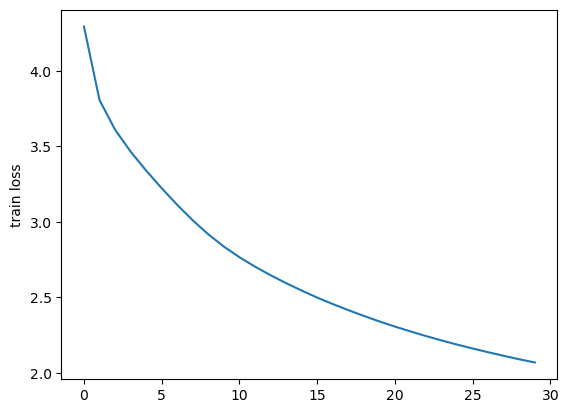

In [15]:
plt.plot(loss_history)
plt.ylabel('train loss')
plt.show()

## 4. 效果测试

In [16]:
model = GPT().to(device)
model.load_state_dict(torch.load('model/gpt_chat.pt')) # 加载训练好的模型
model.eval()
ask = "你好啊"
print(model.answer(ask))

你好


In [17]:
ask = "你叫什么名字"
print(model.answer(ask))

金香菇和金香


In [18]:
ask = "今天天气不错"
print(model.answer(ask))

今天天气好了吗
